In [1]:
from __future__ import print_function

from IPython import display

import math
import matplotlib
import sklearn
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from numpy import radians, cos, sin, arcsin, arccos, sqrt, pi, arctan2, degrees, arctan

from tqdm import tqdm, tqdm_notebook
tqdm.pandas()
tqdm.pandas(tqdm_notebook)

from joblib import dump, load

from natsort import natsorted
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split
from sklearn import metrics

pd.options.display.max_rows = 10

In [2]:

def haversine(lat1, lon1, lat2, lon2):
    #ensure using numpy and not math, or pandas series cannot be passed
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * arcsin(sqrt(a))
    r = 6378.137 ##radius of earth km
    return c * r

def compute_dist(df):
    next_df = df.shift(1)
    dist = haversine(df.iloc[:,0], df.iloc[:,1],
                    next_df.iloc[:,0], next_df.iloc[:,1])
    return dist

def compute_time(df):
    next_df = df.shift(1)
#     df["time"] = pd.to_datetime(df["time_utc"], format="%Y-%m-%d %H:%M:%S.%f", errors='raise')
    timedelt = df["time"] - next_df["time"]
    return timedelt

def compute_speed(df):
    kinematics = df.copy()
    kinematics["distance_travelled"] = compute_dist(kinematics[["latitude", "longitude"]].astype(float)).values
    kinematics["time_elapsed"] = compute_time(kinematics).values
    kinematics["time_elapsed_seconds"] = kinematics["time_elapsed"]/np.timedelta64(1,'s')
    kinematics["speed m/s"] = (kinematics["distance_travelled"]*1000)/kinematics["time_elapsed_seconds"]
    kinematics["speed kmh"] = kinematics["speed m/s"]*3.6
    kinematics["bearing"] = compute_bearing(kinematics[["latitude", "longitude"]].astype(float))
    kinematics['bearing_diff'] = compute_bearing_diff(kinematics)
    kinematics["rate_of_turn"] = kinematics["bearing_diff"]/kinematics["time_elapsed_seconds"]
    kinematics["acceleration"] = (speed_diff(kinematics["speed m/s"])) /kinematics["time_elapsed_seconds"]
    kinematics.drop(columns = ['time_elapsed'], inplace = True)
    kinematics.fillna(0, inplace = True)
#     df["distance_travelled"] = kinematics["distance_travelled"].values
#     df["speed kmh"] = kinematics["speed kmh"].values
    return kinematics

def compute_bearing(df):
    next_df = df.shift(1)
    bear = cal_bearing(df.iloc[:,0], df.iloc[:,1],
                    next_df.iloc[:,0], next_df.iloc[:,1])
    return bear

def bearing_diff(bearing, prev_bearing):
    
    """
    Calculates the absolute difference between two angles
    Parameters
      bearing: bearing in degrees of the first angle
      prev_bearing: bearing in degrees of the second angle
    Returns the difference in degrees as a float
    """

    # if bearing - prev_bearing <=180 then taking the absolute difference is correct
    if bearing - prev_bearing <= 180:
        bearing_diff = abs(bearing - prev_bearing)
    # otherwise if bearing is larger than previous_bearing the total difference is the prev_bearing plus the difference
    # between 360 and the bearing
    elif bearing > prev_bearing:
        bearing_diff = prev_bearing + (360 - bearing)
    # otherwise if prev_bearing is larger than bearing the total difference is the bearing plus the difference 
    # between 360 and the prev_bearing
    elif prev_bearing > bearing:
        bearing_diff = bearing + (360 - prev_bearing)
    # in all other cases take the absolute difference
    else:
        bearing_diff = abs(bearing - prev_bearing)

    return bearing_diff

def cal_bearing(lat1, lon1, lat2, lon2):
    """
    Calculates the bearing between two points using the formula
        θ = atan2(sin(Δlong).cos(lat2),
                  cos(lat1).sin(lat2) − sin(lat1).cos(lat2).cos(Δlong))
    """
    
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])

    dlon = lon2 - lon1

    x = sin(dlon) * cos(lat2)
    y1 = cos(lat1) * sin(lat2)
    y2 = sin(lat1) * cos(lat2) * cos(dlon)
    y = y1 - y2

    initial_bearing = arctan2(x, y)

    initial_bearing = degrees(initial_bearing)
    compass_bearing = (initial_bearing + 360) % 360

    return compass_bearing

def compute_bearing_diff(df):
    df1 = df.copy()
    df1["prev_bearing"] = df1["bearing"].shift(1)
    df1["bearing diff"] = df1.apply(lambda row: bearing_diff(row['bearing'],row['prev_bearing']),axis=1)
    return df1["bearing diff"]

def speed_diff(df):
    next_df = df.shift(1)
    diff = df - next_df
    return diff

def compute_speed(df):
    kinematics = df.copy()
    kinematics["distance_travelled"] = compute_dist(kinematics[["latitude", "longitude"]].astype(float)).values
    kinematics["time_elapsed"] = compute_time(kinematics).values
    kinematics["time_elapsed_seconds"] = kinematics["time_elapsed"]/np.timedelta64(1,'s')
    kinematics["speed m/s"] = (kinematics["distance_travelled"]*1000)/kinematics["time_elapsed_seconds"]
    kinematics["speed kmh"] = kinematics["speed m/s"]*3.6
    kinematics["bearing"] = compute_bearing(kinematics[["latitude", "longitude"]].astype(float))
    kinematics['bearing_diff'] = compute_bearing_diff(kinematics)
    kinematics["rate_of_turn"] = kinematics["bearing_diff"]/kinematics["time_elapsed_seconds"]
    kinematics["acceleration"] = (speed_diff(kinematics["speed m/s"])) /kinematics["time_elapsed_seconds"]
    kinematics.drop(columns = ['time_elapsed'], inplace = True)
    kinematics.fillna(0, inplace = True)
#     df["distance_travelled"] = kinematics["distance_travelled"].values
#     df["speed kmh"] = kinematics["speed kmh"].values
    return kinematics

In [7]:

def shift5(arr, num, fill_value=np.nan):
    result = np.empty_like(arr)
    if num > 0:
        result[:num] = fill_value
        result[num:] = arr[:-num]
    elif num < 0:
        result[num:] = fill_value
        result[:num] = arr[-num:]
    else:
        result[:] = arr
    return result

def cosrule_arr(arr):
    r = 6378.137
    next_arr = shift5(arr,1)
    c = haversine(arr[:,0], arr[:,1],
                    next_arr[:,0], next_arr[:,1])
    next_arr2 = shift5(next_arr, 1)
    a = haversine(next_arr[:,0], next_arr[:,1],
                    next_arr2[:,0], next_arr2[:,1])
    b = haversine(arr[:,0], arr[:,1],
                    next_arr2[:,0], next_arr2[:,1])
    a = a/r
    b= b/r
    c = c/r
    cosb = (c**2 + a**2 - b**2)/(2*a*c)
    return np.arccos(cosb) * 57.2958

def cosrule(df):
    r = 6378.137
    next_df = df.shift(1)
    c = haversine(df.iloc[:,0], df.iloc[:,1],
                    next_df.iloc[:,0], next_df.iloc[:,1])
    next_df2 = next_df.shift(1)
    a = haversine(next_df.iloc[:,0], next_df.iloc[:,1],
                    next_df2.iloc[:,0], next_df2.iloc[:,1])
    b = haversine(df.iloc[:,0], df.iloc[:,1],
                    next_df2.iloc[:,0], next_df2.iloc[:,1])
    a = a/r
    b= b/r
    c = c/r
    cosb = (c**2 + a**2 - b**2)/(2*a*c)
    return np.arccos(cosb) * 57.2958
def spherical_dist(pos1, pos2, r=6378137):
    '''
    stackexchange 19413259
    '''
    pos1 = pos1 * pi/180
    pos2 = pos2 * pi/180
    cos_lat1 = cos(pos1[..., 1])
    cos_lat2 = cos(pos2[..., 1])
    cos_lat_d = cos(pos1[..., 1] - pos2[..., 1])
    cos_lon_d = cos(pos1[..., 0] - pos2[..., 0])
    return r * arccos(cos_lat_d - cos_lat1 * cos_lat2 * (1 - cos_lon_d))


def time_dif(time1, time2):
    return abs(time1 - time2) / np.timedelta64(1, 's')

def speed_array_calc(df, N, window_size):
    '''
    calculates the distance, time and speed of every point wrt to every other point
    '''
    locations = df[["longitude", "latitude"]].iloc[N:N+window_size].values.astype(float)
    dist_array = spherical_dist(locations[:, None], locations)
    try:
        time_val = np.array(pd.to_datetime(df["time_utc"], format="%Y-%m-%d %H:%M:%S.%f", errors='raise').iloc[N:N+window_size])
    except(KeyError):
        time_val = np.array(pd.to_datetime(df["time"], format="%Y-%m-%d %H:%M:%S.%f", errors='raise').iloc[N:N+window_size])
#     time_val = np.array(pd.to_datetime(kinematics["time"], format="%Y-%m-%d %H:%M:%S.%f", errors='raise'))
    time_array = time_dif(time_val[:, None], time_val)
    speed_array = np.divide(dist_array, time_array)#, out = np.zeros_like(dist_array), where=time_array!=0)
    '''
    calculate z score of the array
    ideally a point very far off from the rest would have high zscore for its speed
    '''
    speed_array = np.ma.array(speed_array, mask = np.isnan(speed_array))
    speed_array = abs(stats.zscore(speed_array, axis=None))
    np.fill_diagonal(speed_array, 0)
    speed_array[speed_array < 1.96] = 0
    speed_array[speed_array > 0 ] = 1
    # # speed_array = scipy.special.expit(speed_array)
    # np.fill_diagonal(speed_array, 0)
    return speed_array

def speed_array_calc_mad(df, N, window_size):
    np.set_printoptions(precision=3)
    locations = df[["longitude", "latitude"]].iloc[N:N+window_size].values.astype(float)
    dist_array = spherical_dist(locations[:, None], locations)
#     print(dist_array)
    time_val = np.array(pd.to_datetime(df["time"], format="%Y-%m-%d %H:%M:%S.%f", errors='raise').iloc[N:N+window_size])
#     time_val = np.array(pd.to_datetime(kinematics["time"], format="%Y-%m-%d %H:%M:%S.%f", errors='raise'))
    time_array = time_dif(time_val[:, None], time_val)
    speed_array = np.divide(dist_array, time_array)#, out = np.zeros_like(dist_array), where=time_array!=0)
    # print(speed_array)

    speed_array = np.ma.array(speed_array, mask = np.isnan(speed_array))

    speed_array = mad_based_outlier(speed_array)
    np.fill_diagonal(speed_array, 0)
    # print(speed_array)
    return speed_array

def mad_based_outlier(points, thresh=3.5):
    shp = points.shape
    points = points.flatten()
    if len(points.shape) ==1:
        points = points[:,None]
    median = np.ma.median(points)
    diff = np.ma.sum((points-median)**2, axis = -1)
    diff = np.ma.sqrt(diff)
    med_abs_deviation = np.ma.median(diff)
    modified_z_score = 0.6745 * diff / med_abs_deviation
    points = modified_z_score > thresh
    points = np.reshape(points, shp)
    return 1*points

def outlier_find(df, window_size):
    '''
    Based on Koyak algorithm for outlier detection
    Generates the list 'out' of indexs which are deemed outliers wrt to other points
    the input A array is still experimental
    '''
    out = np.zeros(0)
    for N in range(0, df.shape[0], window_size):
        A = speed_array_calc_mad(df, N, window_size)
        n = A.shape[0]
        b = np.sum(A, axis = 1)
        o = np.zeros(shape = n)
        while ((np.amax(b) > 0)):
            r = np.argmax(b)
            o[r] = 1
            b[r] = 0
            for j in range (0, n):
                if (o[j] == 0):
                    b[j] = b[j] - A[r][j]
        out = np.append(out, o)
    return out


In [64]:
tt = pd.read_csv('./4798.txt', header  = None, parse_dates = [1])
tt.columns = ['ID', 'time', 'longitude', 'latitude']

In [92]:
tt

,ID,time,longitude,latitude
0,4798,2008-02-02 13:30:52,116.35029,39.89919
1,4798,2008-02-02 13:30:57,116.35027,39.89871
2,4798,2008-02-02 13:31:02,116.35012,39.89818
3,4798,2008-02-02 13:31:07,116.34975,39.89768
4,4798,2008-02-02 13:31:12,116.34917,39.89730
...,...,...,...,...
92131,4798,2008-02-08 17:38:32,116.33048,39.93694
92132,4798,2008-02-08 17:38:42,116.32824,39.93697
92133,4798,2008-02-08 17:38:47,116.32713,39.93705
92134,4798,2008-02-08 17:38:57,116.32523,39.93720


In [116]:
foo = tt[tt['time'] < '2008-2-2 13:43' ]

In [117]:
foo.drop_duplicates(subset = ['time'], inplace = True)

/home/ericlow/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [118]:
wz = int(30 * arctan(0.005*foo.shape[0]))

if (wz > 5):
    outliers = outlier_find(foo, window_size=wz).astype(bool)
else:
    outliers = np.zeros(foo.shape[0]).astype(bool)

foo = foo[~outliers]
# outliers = outlier_find(foo, window_size=wz).astype(bool)
# foo = foo[~outliers]
#         polyline = ast.literal_eval(row['POLYLINE'])
a = np.array(foo[['time', 'longitude', 'latitude']].values)
ang = cosrule_arr(a[:,1:].astype(float))
a = np.append(a, ang.reshape(-1,1), axis = 1)
# a = np.append(a, np.array(ts).reshape(-1,1), axis =1)

/home/ericlow/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: RuntimeWarning: invalid value encountered in true_divide
/home/ericlow/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide


In [119]:
while (a[:,3] < 20).any():
    a = a[~shift5(a[:,3] < 30, -1)] 
    a[:,3] = cosrule_arr(a[:,1:3].astype(float))
    
b = pd.DataFrame.from_records(a[:,0:3])
b.columns = ['time', 'longitude', 'latitude']

/home/ericlow/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide


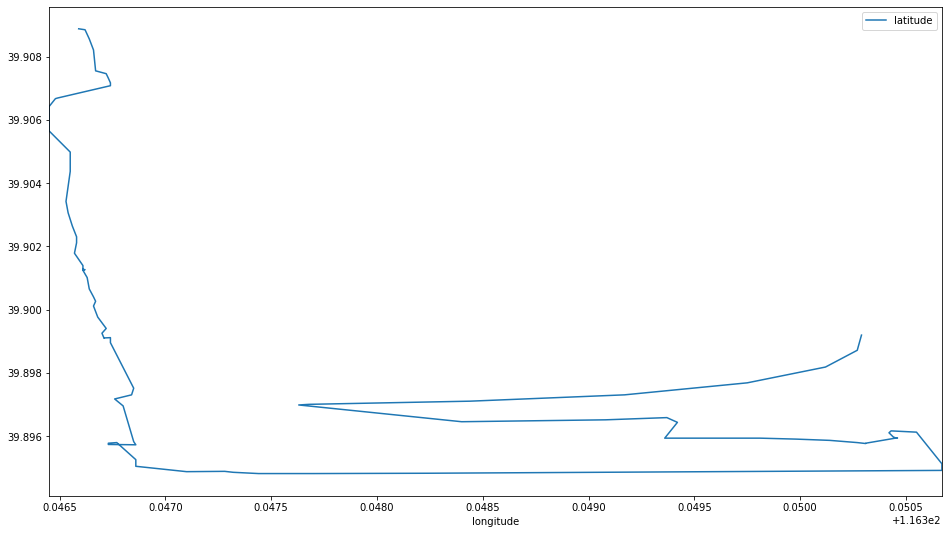

In [123]:
b.plot('longitude', 'latitude', figsize = (16,9))

In [121]:
df2 = compute_speed(b)

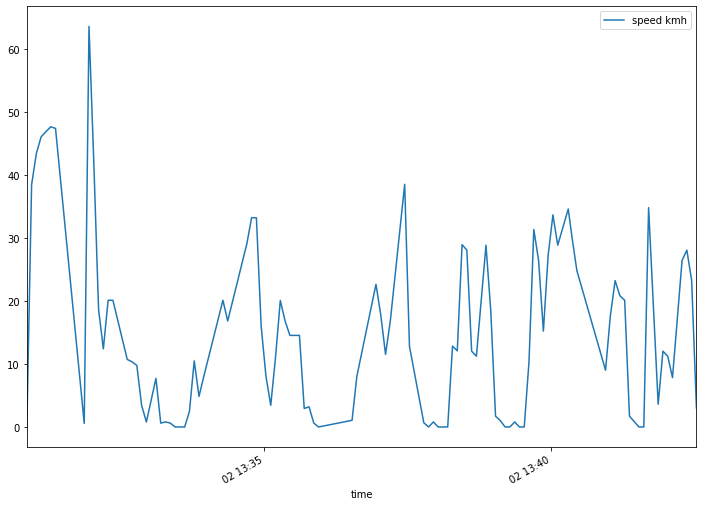

In [122]:
df2.plot('time', 'speed kmh', figsize = (12,9))

In [91]:
def time_to_dest(df):
    end_time = df['time'].iloc[-1]
    df['time_to_dest'] = (end_time - df['time']).dt.total_seconds().astype(int)
def set_dropoff(df):
    df['dropoff_latitude'] = df['latitude'].iloc[-1]
    df['dropoff_longitude'] = df['longitude'].iloc[-1]


In [171]:
time_to_dest(df2)
set_dropoff(df2)

df2['dist_to_dest'] = haversine(df2['latitude'].values, df2['longitude'].values, df2['dropoff_latitude'].values, df2['dropoff_longitude'].values)

In [172]:
df2['pickup_weekday'] = df2['time'].dt.weekday
df2['pickup_hour_weekofyear'] = df2['time'].dt.weekofyear
df2['pickup_hour'] = df2['time'].dt.hour
df2['pickup_minute'] = df2['time'].dt.minute
df2['pickup_dt'] = (df2['time'] - df2['time'].min()).dt.total_seconds()
df2['pickup_week_hour'] = df2['pickup_weekday'] * 24 + df2['pickup_hour']

In [173]:
df2

,Unnamed: 0,time,longitude,latitude,ID,distance_travelled,time_elapsed_seconds,speed m/s,speed kmh,bearing,...,time_to_dest,dropoff_latitude,dropoff_longitude,dist_to_dest,pickup_weekday,pickup_hour_weekofyear,pickup_hour,pickup_minute,pickup_dt,pickup_week_hour
78690,0,2013-07-01 10:55:57,-8.607096,41.150331,20000001,0.000000,0.0,0.000000,0.000000,0.000000,...,765,41.174712,-8.565732,4.402649,0,27,10,55,0.0,10
78691,1,2013-07-01 10:56:12,-8.607096,41.150313,20000001,0.002004,15.0,0.133583,0.480900,0.000000,...,750,41.174712,-8.565732,4.403885,0,27,10,56,15.0,10
78692,2,2013-07-01 10:56:27,-8.607141,41.150241,20000001,0.008858,15.0,0.590549,2.125975,25.202430,...,735,41.174712,-8.565732,4.411801,0,27,10,56,30.0,10
78693,3,2013-07-01 10:56:42,-8.607150,41.150232,20000001,0.001254,15.0,0.083609,0.300994,36.979259,...,720,41.174712,-8.565732,4.413013,0,27,10,56,45.0,10
78694,4,2013-07-01 10:56:57,-8.607600,41.149233,20000001,0.117431,15.0,7.828743,28.183474,18.736059,...,705,41.174712,-8.565732,4.511826,0,27,10,56,60.0,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78732,42,2013-07-01 11:07:42,-8.567118,41.174604,20000001,0.076792,15.0,5.119464,18.430072,214.721015,...,60,41.174712,-8.565732,0.116755,0,27,11,7,705.0,11
78733,43,2013-07-01 11:07:57,-8.567118,41.174568,20000001,0.004008,15.0,0.267167,0.961800,0.000000,...,45,41.174712,-8.565732,0.117235,0,27,11,7,720.0,11
78734,44,2013-07-01 11:08:12,-8.566569,41.175000,20000001,0.066549,15.0,4.436591,15.971727,223.728363,...,30,41.174712,-8.565732,0.077113,0,27,11,8,735.0,11
78735,45,2013-07-01 11:08:27,-8.565768,41.175162,20000001,0.069497,15.0,4.633108,16.679190,254.960394,...,15,41.174712,-8.565732,0.050185,0,27,11,8,750.0,11


In [188]:
train_x = df2.drop(['Unnamed: 0', 'time', 'ID', 'time_elapsed_seconds', 'time_to_dest'] ,axis =1)
train_y = df2[['time_to_dest']]

In [189]:
x_data = train_x.values
x_data = np.array(x_data)
# x_data = x_data.reshape(19828,5,1)
x_data.shape

(47, 18)

In [190]:
y_data = train_y.values
y_data.shape

(47, 1)

In [191]:

from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers.recurrent import LSTM,RNN
from tensorflow.python.keras.layers.core import Dense, Activation, Dropout

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [238]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42)

In [239]:
# sc = MinMaxScaler(feature_range=(-1,1))
scy = MinMaxScaler(feature_range=(-1,1))
sc = sklearn.preprocessing.StandardScaler()
# new_df= x_data[].reshape(x_data.shape[0],5)

x_train = sc.fit_transform(x_train)
x_train = x_train.reshape(37,18,1)
x_test = sc.transform(x_test).reshape(10,18,1)


y_train = scy.fit_transform(y_train)
y_test = scy.transform(y_test)

# new_y_data = y_data
# new_y_data = scy.fit_transform(y_)

In [240]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(37, 18, 1)
(37, 1)
(10, 18, 1)
(10, 1)


In [252]:
model = Sequential()

# first layer
model.add(LSTM(units=100, batch_input_shape=(None,18,1),return_sequences=True))
model.add(Dropout(0.2))

# second layer
# model.add(Dense(128, 1))
model.add(LSTM(units=100,return_sequences=True))
model.add(Dropout(0.2))

# third layer
model.add(LSTM(units=50,return_sequences=False))
model.add(Dropout(0.2))

# fourth dense layer
model.add(Dense(units=1))


model.compile(loss='mean_absolute_error',optimizer='adam',metrics=['mae'])
model.summary()
          

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_35 (LSTM)               (None, 18, 100)           40800     
_________________________________________________________________
dropout_35 (Dropout)         (None, 18, 100)           0         
_________________________________________________________________
lstm_36 (LSTM)               (None, 18, 100)           80400     
_________________________________________________________________
dropout_36 (Dropout)         (None, 18, 100)           0         
_________________________________________________________________
lstm_37 (LSTM)               (None, 50)                30200     
_________________________________________________________________
dropout_37 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)               

In [253]:
model.fit(x_train,y_train,epochs=50,validation_data=(x_test,y_test))

Train on 37 samples, validate on 10 samples
Epoch 1/50
37/37 [==============================] - 3s 78ms/sample - loss: 0.5382 - mean_absolute_error: 0.5382 - val_loss: 0.3942 - val_mean_absolute_error: 0.3942
Epoch 2/50
37/37 [==============================] - 0s 4ms/sample - loss: 0.5144 - mean_absolute_error: 0.5144 - val_loss: 0.3538 - val_mean_absolute_error: 0.3538
Epoch 3/50
37/37 [==============================] - 0s 4ms/sample - loss: 0.4905 - mean_absolute_error: 0.4905 - val_loss: 0.3180 - val_mean_absolute_error: 0.3180
Epoch 4/50
37/37 [==============================] - 0s 4ms/sample - loss: 0.4456 - mean_absolute_error: 0.4456 - val_loss: 0.3034 - val_mean_absolute_error: 0.3034
Epoch 5/50
37/37 [==============================] - 0s 4ms/sample - loss: 0.3590 - mean_absolute_error: 0.3590 - val_loss: 0.3192 - val_mean_absolute_error: 0.3192
Epoch 6/50
37/37 [==============================] - 0s 4ms/sample - loss: 0.3898 - mean_absolute_error: 0.3898 - val_loss: 0.3626 - val

In [254]:
result = model.predict(x_test)
result

array([[-0.23124474],
       [ 0.02377468],
       [-0.09108256],
       [-0.00299612],
       [ 0.18128891],
       [-0.26701593],
       [ 0.66691774],
       [ 0.38794914],
       [ 0.6715868 ],
       [ 0.15612999]], dtype=float32)

In [255]:
res_df = scy.inverse_transform(result)

In [256]:
y_test_actual=scy.inverse_transform(y_test)

In [257]:
res_df

array([[294.0489 ],
       [391.59378],
       [347.66092],
       [381.35397],
       [451.84302],
       [280.3664 ],
       [637.59607],
       [530.89056],
       [639.38196],
       [442.2197 ]], dtype=float32)

In [258]:
y_test_actual

array([[285.],
       [105.],
       [315.],
       [ 45.],
       [345.],
       [150.],
       [540.],
       [435.],
       [705.],
       [330.]])